<a href="https://colab.research.google.com/github/PhoenixCC0722/Journey_to_become_DataScientist/blob/main/Chapter7_supervised_ML_onehotEncoding__Housing_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Housing prices with more features

New features are included in the original dataset:


LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive,MSZoning,Condition1,Heating,Street,CentralAir,Foundation,,



### **Step 1. Data reading & splitting**

In [1]:
# required packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

In [2]:
# 1st way
import pandas as pd
url = "https://drive.google.com/file/d/19WTPo9Rn_Cc3CJcqOJ6Wjw93wx3PxDFT/view?usp=sharing" # the .csv file is already uploaded from local server to the colad in google drive. In colab notebook, 'share' --> anyone with the link --> 'copy the link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

data = pd.read_csv(path)
data.columns

Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'Expensive',
       'MSZoning', 'Condition1', 'Heating', 'Street', 'CentralAir',
       'Foundation'],
      dtype='object')

In [3]:
# 2nd way
# Get the spreadsheet ID and name
# google sheets address: https://docs.google.com/spreadsheets/d/1JSxdY2rj2HbiNc-bn236Z9w7j0-fi__VDvIyBWH7ovU/edit?gid=1374956379#gid=1374956379

sheet_id = "1JSxdY2rj2HbiNc-bn236Z9w7j0-fi__VDvIyBWH7ovU"
sheet_name = "1374956379"

# Construct the URL to the CSV export of the spreadsheet
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={sheet_name}"

# Read the CSV data into a Pandas DataFrame
data = pd.read_csv(url)
data.columns

Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'Expensive',
       'MSZoning', 'Condition1', 'Heating', 'Street', 'CentralAir',
       'Foundation'],
      dtype='object')

In [4]:
X = data
X.columns
X.dtypes

LotArea           int64
LotFrontage     float64
TotalBsmtSF       int64
BedroomAbvGr      int64
Fireplaces        int64
PoolArea          int64
GarageCars        int64
WoodDeckSF        int64
ScreenPorch       int64
Expensive         int64
MSZoning         object
Condition1       object
Heating          object
Street           object
CentralAir       object
Foundation       object
dtype: object

In [5]:
y = X.pop('Expensive')

In [6]:
# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### **Step 3. Categorical encoding - "Automated" approach (Using Pipelines)**

In the manual approach, to encode the categorical columns numerically, we have:

1. Selected the categorical columns.
2. Fitted a OneHotEncoder to them.
3. Transformed the categorical columns with the encoder.
4. Converted the sparse matrix into a dataframe.
5. Recovered the names of the columns.
6. Concatenated the one-hot columns with the numerical columns.

All these steps can be synthetised by using Scikit-Learn Pipelines and specifically something called ColumnTransformer, which allows us to apply different transformations to two or more groups of columns: in our case, categorical and numerical columns.

This process is also called creating "branches" in the pipeline. One branch for the categorical columns and another for the numerical columns. Each branch will contain as many transformers as we want. Then, the branches will meet again, and the transformed columns will be automatically concatenated. Let's see the process in action:

### 3.1. Creating the "numeric pipe" and the "categoric pipe"

In [7]:
# import
from sklearn.preprocessing import OneHotEncoder

In [8]:
# select categorical and numerical column names
X_cat_columns = X.select_dtypes(exclude="number").columns
X_num_columns = X.select_dtypes(include="number").columns

# create numerical pipeline, only with the SimpleImputer(strategy="mean")
numeric_pipe = make_pipeline(
    SimpleImputer(strategy="mean"))

 # create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
categoric_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    OneHotEncoder(sparse_output=False,handle_unknown='infrequent_if_exist',min_frequency=0.03)
)

In [9]:
X_cat_columns

Index(['MSZoning', 'Condition1', 'Heating', 'Street', 'CentralAir',
       'Foundation'],
      dtype='object')

In [10]:
categoric_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='N_A', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='infrequent_if_exist',
                               min_frequency=0.03, sparse_output=False))])

### 3.2. Using ColumnTransformer a pipeline with 2 branches (the preprocessor)

We simply tell the pipeline the following:

*   One branch, called "num_pipe", will apply the steps in the numeric_pipe to the columns named in X_num_columns
*   The second branch, called "cat_pipe", will apply the steps in the categoric_pipe to the columns named in X_cat_columns

In [11]:
from sklearn.compose import make_column_transformer

preprocessor = make_column_transformer(
    (numeric_pipe, X_num_columns),
    (categoric_pipe, X_cat_columns),
)

### 3.3. Creating the full_pipeline (preprocessor + Decision Tree)

Pipelines are modular. The preprocessor we created above with the ColumnTransformer can become now a step in a new pipeline, that we'll call full_pipeline and will include, as a last step, a Decision Tree model:

In [12]:
full_pipeline = make_pipeline(preprocessor,
                              DecisionTreeClassifier())

In [13]:
# Notice that we did not fit the `preprocessor` before — we only fit the pipeline once it has been fully assembled.
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch'],
      dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='N_A',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.03,
                                                                                 sparse_output=False))]),
                                                  Index(['MSZoning', 'Condition1', 'Heating', 'Street', 'CentralAir',
       'Foundation'],
      dtype='object'))])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

This full pipeline can make predictions, as can any other pipeline that ends with a model:

In [14]:
full_pipeline.predict(X_train)

array([1, 0, 1, ..., 1, 0, 0])

In [15]:
from sklearn.model_selection import GridSearchCV

# define parameter grid
param_grid = {
    "decisiontreeclassifier__max_depth": range(2, 14, 2),
    "decisiontreeclassifier__min_samples_leaf": range(3, 12, 2)
}

# define GridSearchCV
search = GridSearchCV(full_pipeline,
                      param_grid,
                      cv=5,
                      verbose=1)

search.fit(X_train, y_train)

scores = {"dtree" : search.best_score_}

scores

Fitting 5 folds for each of 30 candidates, totalling 150 fits


{'dtree': 0.9186786985070248}

### 3.4 Accessing steps of the pipeline

The estimators of a pipeline are stored as a list in the steps attribute, but can be accessed by index or name by indexing the Pipeline:

In [16]:
# first step in our pipeline is Simpleimputer

# we can access it with an index
full_pipeline[0]

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch'],
      dtype='object')),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='N_A',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=0.03,
                                                                sparse_output=False))]),
                                 Index(['MSZoning', 'Condition1', 'Heating', 'Street', 'CentralAir',
       'Foundation'],
      dtype='object'))])

In [17]:
# or by it's name
full_pipeline['columntransformer']

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch'],
      dtype='object')),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='N_A',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=0.03,
                                                                sparse_output=False))]),
                                 Index(['MSZoning', 'Condition1', 'Heating', 'Street', 'CentralAir',
       'Foundation'],
      dtype='object'))])

named_steps helps you navigate through the pipeline.
When using it, you get the autocompletion active after every step.
With `get_features_names_out()' you can get printed column names that specific estimator used

In [18]:
(full_pipeline
 .named_steps.columntransformer
 .named_transformers_['pipeline-1']
 .named_steps.simpleimputer
 .get_feature_names_out()
 )

array(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr',
       'Fireplaces', 'PoolArea', 'GarageCars', 'WoodDeckSF',
       'ScreenPorch'], dtype=object)

We can also get parameters out of any specific step, e.g. catogeries from onehotencoder step:

In [19]:
full_pipeline.named_steps.columntransformer.named_transformers_['pipeline-2'].named_steps.onehotencoder.categories_

[array(['C (all)', 'FV', 'RH', 'RL', 'RM'], dtype=object),
 array(['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNe',
        'RRNn'], dtype=object),
 array(['Floor', 'GasA', 'GasW', 'Grav', 'OthW', 'Wall'], dtype=object),
 array(['Grvl', 'Pave'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['BrkTil', 'CBlock', 'PConc', 'Slab', 'Stone', 'Wood'], dtype=object)]

### 3.5 Including the imputer to the GridSearchCV

If you want to include a parameter to the parameter grid you have to navigate through the pipe. For example, if one wants to include the SimpleImputer of the numerical pipe into the grid search the path to the SimpleImputer must be given. In this case the path is: columntransformet-pipeline-1-simpleimputer. One can see every step on the diagram of the pipe. Have in mind that in the parameter grid dictionary each step is distinguished one from another by the two lower dashes ("__")

In [20]:
from sklearn.model_selection import GridSearchCV

# define parameter grid
param_grid = {
    "columntransformer__pipeline-1__simpleimputer__strategy":["mean", "median"],
    "decisiontreeclassifier__max_depth": range(2, 14, 2),
    "decisiontreeclassifier__min_samples_leaf": range(3, 12, 2)
}

# define GridSearchCV
search = GridSearchCV(full_pipeline,
                      param_grid,
                      cv=5,
                      verbose=1)

search.fit(X_train, y_train)

best_param = search.best_params_

best_param

Fitting 5 folds for each of 60 candidates, totalling 300 fits


{'columntransformer__pipeline-1__simpleimputer__strategy': 'mean',
 'decisiontreeclassifier__max_depth': 4,
 'decisiontreeclassifier__min_samples_leaf': 9}

### 3.6. Use the new Pipeline with branches to train a DecisionTree with GridSearch cross validation

In [26]:
# Selecting numerical columns
X_train_num = X_train.select_dtypes(include="number")

# Imputing the mean
num_imputer = SimpleImputer(strategy="mean").set_output(transform='pandas')

# Fitting and transforming
X_num_imputed = num_imputer.fit_transform(X_train_num)

X_num_imputed.head()

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch
318,9900.0,90.000000,1347.0,4.0,1.0,0.0,3.0,340.0,0.0
580,14585.0,69.588957,1144.0,3.0,2.0,0.0,2.0,216.0,0.0
961,12227.0,69.588957,1330.0,4.0,1.0,0.0,2.0,550.0,0.0
78,10778.0,72.000000,1768.0,4.0,0.0,0.0,0.0,0.0,0.0
5,14115.0,85.000000,796.0,1.0,0.0,0.0,2.0,40.0,0.0


In [27]:
from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer().set_output(transform='pandas') # initialize
my_imputer.fit(X_train_num) # fit on the train set
X_num_imputed_train = my_imputer.transform(X_train_num) # transform the train set
# X_num_imputed_test = my_imputer.transform(X_num_test) # transform the test set

In [30]:
# default value of filter: criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_samples_splitint or float, default=2.
# initialize the model
my_tree_best_param = DecisionTreeClassifier(criterion='gini',
                                            max_depth=4,
                                            min_samples_leaf=9,
                                           )

In [31]:
# fit the model to the train data
my_tree_best_param.fit(X = X_num_imputed_train,
            y = y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=9)

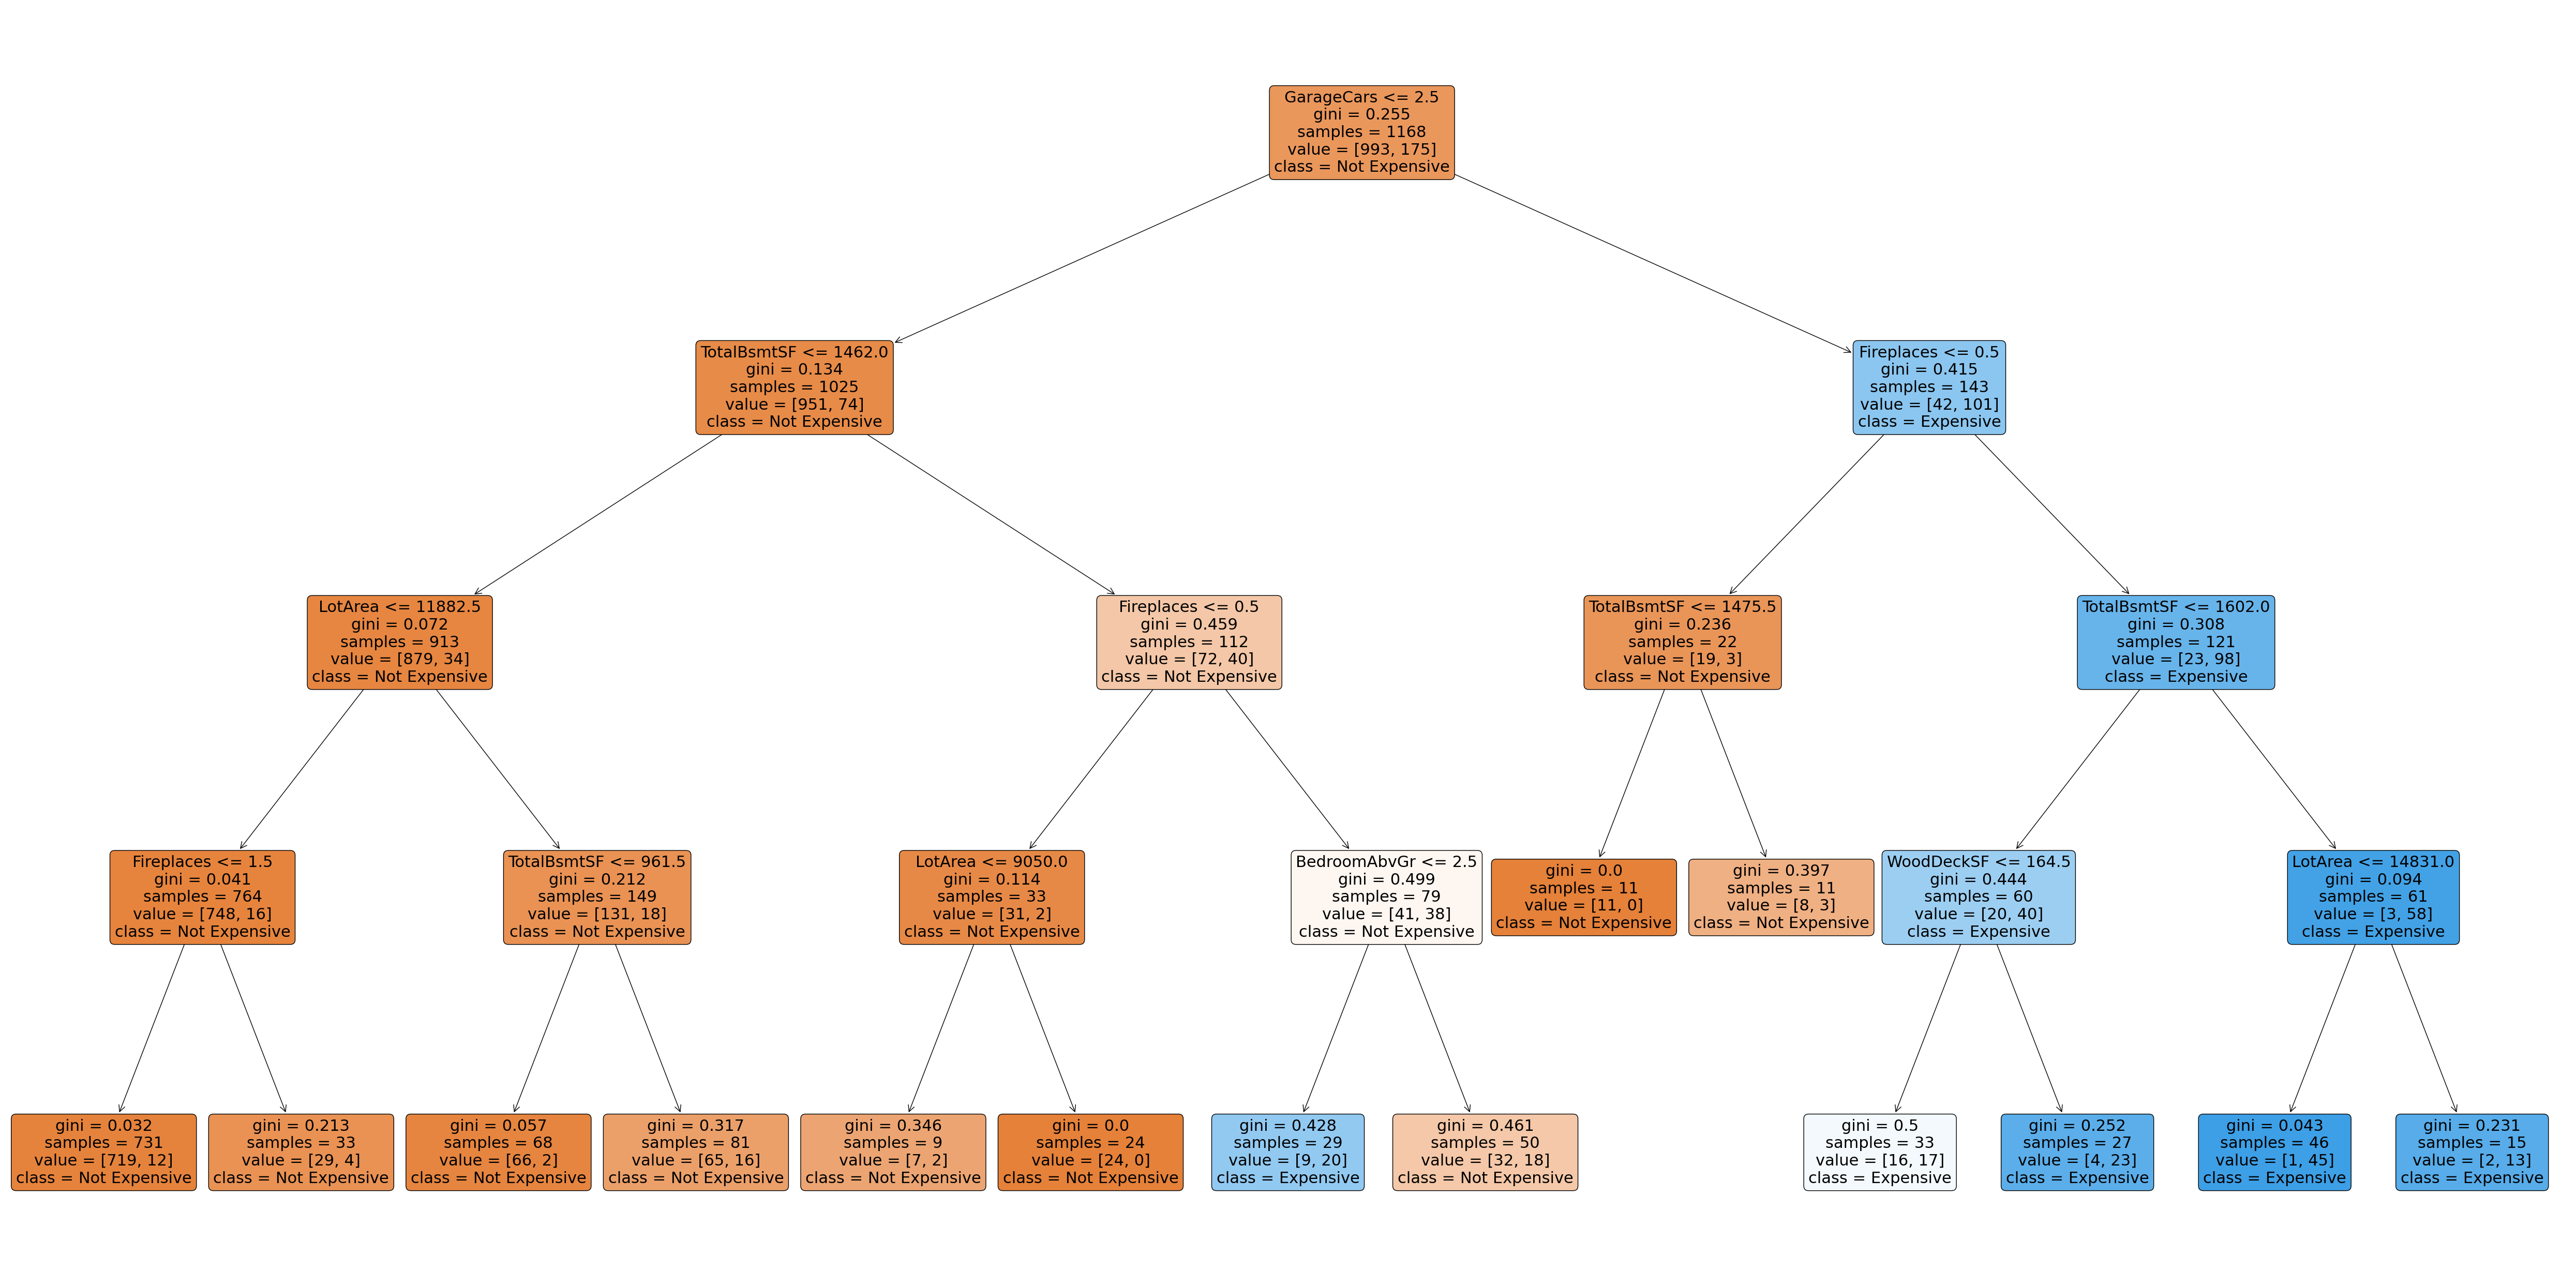

In [32]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

X_num = X.select_dtypes(include="number")
plt.figure(figsize=(64, 32))

plot_tree(
     my_tree_best_param,
     filled=True,
     rounded=True,
     class_names=['Not Expensive','Expensive'],
     feature_names=X_num.columns
     );